<a href="https://colab.research.google.com/github/chan-kh/Music-Sentiment-Analysis/blob/main/LSTM_2outputs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [114]:
import os
import datetime
from google.colab import drive

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import MinMaxScaler

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

from keras import layers
from keras.optimizers import RMSprop
from keras.layers import Bidirectional

from math import sqrt
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [115]:
drive.mount("/content/drive")
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Sentiment/features_60frames_allsongs.csv')
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,song_id,frame_num,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,valence,arousal
0,2,0,0.157715,0.000011,5604.262879,3246.069688,9549.975586,18.349374,0.283305,0.000000,-636.134705,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.654255,0.699066,0.261531,0.874848,1.000000,0.333313,0.812421,0.488101,0.413135,0.640419,0.671442,0.490904,0.725918,0.250459,0.284098,0.647150,0.349017,0.147453,0.501239,0.074669,0.070883,0.633342,0.184297,0.136420,0.700169,0.030602,0.209675,0.828279,0.124886,0.257948,1.000000,0.071105,0.309559,0.798000,0.076693,0.276441,-0.134078,0.072852,-0.134683,0.086125,0.060471,0.042898,-0.073341,-0.109386
1,2,1,0.051758,0.096817,1443.667160,2057.611806,3036.181641,27.017306,0.003931,1.576688,-120.319748,129.464996,-4.253306,22.214062,8.163963,16.415987,15.152133,7.878392,-6.823561,-0.831550,-7.218902,-4.558928,-1.807601,12.948887,-9.162554,-3.758020,-5.506585,-1.227700,-4.439484,1.684063,0.528904,0.624552,0.263783,0.891966,0.850903,0.331133,1.000000,1.000000,0.408033,0.713866,0.681263,0.480444,0.245905,0.378263,0.278916,0.160639,0.397115,0.147040,0.285743,0.536704,0.072041,0.314144,0.652729,0.144099,0.269362,0.637670,0.218737,0.382769,0.677961,0.263132,0.424450,0.649488,0.317883,0.517798,0.579528,0.282752,-0.088692,0.052331,-0.112961,0.075804,0.041915,0.033029,-0.074661,-0.114942
2,2,2,0.101562,0.096426,2348.097128,2387.006355,4941.870117,22.434103,0.013857,0.152583,-107.915352,76.319107,-14.175928,45.124214,1.209538,7.516734,-5.023264,6.480774,-0.513962,8.108901,-0.198636,-3.022716,2.078595,4.819644,-16.200150,-3.348299,-5.746615,-9.680576,-17.688511,-5.846364,0.190785,0.290683,0.265836,0.206553,0.217986,0.329024,0.491271,0.576434,0.402986,1.000000,0.924618,0.469653,0.706139,0.605435,0.273279,0.307669,0.224213,0.146400,0.107266,0.206321,0.073380,0.222554,0.297425,0.151825,0.408395,0.409732,0.227828,0.563377,0.734764,0.268284,0.755202,1.000000,0.326054,0.528056,0.687259,0.288720,-0.034494,0.031843,-0.070020,0.068549,0.021691,0.023202,-0.074077,-0.116413
3,2,3,0.062500,0.086847,1692.187106,1872.280637,3219.213867,21.295763,0.004178,0.224268,-148.255432,121.565720,-36.703545,33.151939,4.518500,5.197342,-8.610166,4.267920,8.706326,-17.273952,-11.429454,4.515498,-7.324573,4.467141,-13.720921,-3.195490,-3.931114,-7.317858,-15.654930,-15.824336,0.245845,0.300974,0.267710,0.523842,0.578168,0.326966,1.000000,0.842026,0.397746,0.846539,1.000000,0.458391,0.477668,0.673670,0.267148,0.095004,0.189054,0.145584,0.031817,0.101448,0.075003,0.024125,0.114284,0.159790,0.044276,0.137589,0.237066,0.215029,0.300263,0.273559,0.177739,0.341496,0.334054,0.110806,0.207098,0.294537,-0.013095,0.020309,-0.055259,0.034349,0.011610,0.012032,-0.078154,-0.118613
4,2,4,0.120605,0.113167,2632.895857,2453.043616,5329.467773,18.914987,0.025196,1.035493,-71.919838,76.267471,-28.003765,15.988888,4.667567,35.548042,-6.664427,-5.128408,9.827440,-1.635414,-5.240368,-1.569069,-1.458279,7.581460,-16.175152,-6.295955,-9.435411,-3.781498,-8.782184,-7.635081,0.223808,0.355715,0.269517,0.202841,0.376315,0.324933,0.624933,0.684395,0.392219,1.000000,1.000000,0.446547,0.319092,0.

In [116]:
df.shape

(104640, 74)

In [117]:
df =df.iloc[np.random.permutation(np.arange(104640).reshape(-1,60)).ravel()]

In [118]:
# df.to_csv('/content/drive/My Drive/Colab Notebooks/Sentiment/shuffled_data.csv',index=False)

In [119]:
df.shape

(104640, 74)

In [120]:
df.pop('song_id')
df.pop('frame_num')

39960     0
39961     1
39962     2
39963     3
39964     4
         ..
98095    55
98096    56
98097    57
98098    58
98099    59
Name: frame_num, Length: 104640, dtype: int64

In [121]:
y = df.loc[:,'valence':'arousal']
print(y.shape)
y.head()

(104640, 2)


,valence,arousal
39960,-0.060463,0.418399
39961,-0.065400,0.415436
39962,-0.071580,0.415465
39963,-0.073187,0.415870
39964,-0.076565,0.416763


In [122]:
df.pop('valence')
df.pop('arousal')

39960    0.418399
39961    0.415436
39962    0.415465
39963    0.415870
39964    0.416763
           ...   
98095    0.031000
98096    0.042000
98097    0.052000
98098    0.051000
98099    0.056000
Name: arousal, Length: 104640, dtype: float64

In [123]:
df.head()


,zcr,rms,spectral_centroid,spectral_bandwidth,spectral_rolloff,spectral_contrast,spectral_flatness,melspectrogram,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,chroma_stft_0,chroma_stft_1,chroma_stft_2,chroma_stft_3,chroma_stft_4,chroma_stft_5,chroma_stft_6,chroma_stft_7,chroma_stft_8,chroma_stft_9,chroma_stft_10,chroma_stft_11,chroma_cqt_0,chroma_cqt_1,chroma_cqt_2,chroma_cqt_3,chroma_cqt_4,chroma_cqt_5,chroma_cqt_6,chroma_cqt_7,chroma_cqt_8,chroma_cqt_9,chroma_cqt_10,chroma_cqt_11,chroma_cens_0,chroma_cens_1,chroma_cens_2,chroma_cens_3,chroma_cens_4,chroma_cens_5,chroma_cens_6,chroma_cens_7,chroma_cens_8,chroma_cens_9,chroma_cens_10,chroma_cens_11,tonnetz_0,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5
39960,0.165039,0.000011,5667.576135,3120.443963,9248.510742,25.513039,0.288461,0.000000,-548.482117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.651374,1.000000,0.243892,0.977907,0.482956,0.251677,0.855603,0.747943,0.361171,0.578778,0.184762,0.365800,0.815059,0.625784,0.270756,1.000000,0.057374,0.224551,0.891101,0.709258,0.206921,0.551547,0.230159,0.166393,0.580713,0.454790,0.261557,0.792394,0.424633,0.381751,0.679622,0.258981,0.372554,0.775400,0.523566,0.256406,0.161065,-0.064690,-0.004645,0.063926,-0.014114,0.055075
39961,0.184570,0.312467,3588.552029,2852.290715,7149.023438,15.716941,0.090383,0.527378,67.394066,39.783081,-14.080101,20.612879,8.807822,11.837675,-6.901147,4.617426,-17.015179,-6.288823,-5.105113,-5.510829,-20.288630,-1.609375,-5.296830,-11.897451,-12.024870,-4.454959,-9.834778,-12.669928,0.265974,0.730023,0.241871,0.257112,0.807300,0.251879,0.231120,0.695305,0.362152,0.351749,0.962148,0.368776,1.000000,0.793982,0.270303,0.356712,0.445980,0.226589,0.148288,0.286093,0.203738,0.176906,0.428927,0.164651,0.267239,0.658601,0.255186,0.382823,0.811007,0.381961,0.618367,1.000000,0.374835,0.327032,0.781213,0.257615,0.042863,-0.004928,-0.011023,0.014830,-0.003315,0.016671
39962,0.227539,0.306920,3735.304049,2834.922007,7321.289062,15.597039,0.117161,0.284939,70.323280,36.275841,-14.611403,19.768396,2.433039,7.422261,2.366732,5.368042,-26.255630,-2.814520,-11.883725,-13.978677,-14.262142,-0.626077,-9.674009,-7.289151,-10.305712,-10.015486,-9.210123,-7.055490,0.222531,0.552481,0.240020,0.234608,0.588076,0.252349,0.286566,0.584094,0.363042,0.296485,0.517411,0.371221,0.229973,0.582323,0.270073,0.269352,0.469365,0.228678,0.305188,0.416528,0.201012,0.321657,0.518243,0.163266,1.000000,0.934790,0.248976,0.603521,0.934719,0.381920,0.687596,1.000000,0.376789,0.325636,0.758821,0.258823,0.004597,0.005563,-0.006490,0.010523,-0.009156,0.008251
39963,0.177246,0.242247,3079.618268,2585.534689,6341.528320,22.140881,0.047637,0.021133,34.024212,61.547016,-20.742020,23.041811,-8.538760,-2.680436,-7.381138,8.545965,-20.291327,-2.466397,-6.818861,-5.069225,-23.284397,-2.592462,-7.269653,-28.720421,-12.773108,-14.736282,-10.931147,-6.216501,0.253412,0.300134,0.238350,0.377579,0.526991,0.253131,0.283961,0.476062,0.363776,0.692459,0.613241,0.373233,0.891905,0.570759,0.270019,0.457401,0.487625,0.230801,0.418796,0.399491,0.198636,0.286352,0.314898,0.162259,0.658718,0.691503,0.243000,1.000000,1.000000,0.381695,0.320593,0.463737,0.378372,0.187311,0.271292,0.260017,-0.006239,0.011097,-0.022108,-0.054293,0.011641,0.007316
39964,0.175293,0.270167,3009.758758,2568.504291,6212.329102,23.383915,0.053116,0.078230,47.153736,63.591167,-34.500000,5.022798,5.270483,8.933895,-9.554054,14.914917,-13.951343,0.526648,-5.752478,-2.948970,-14.604290,-0.923068,3.601987,-7.092714,-3.962058,-1.157212,-10.405791,-9.128297,0.272481,0.526591,0.236862,0.366886,0.754083,0.254343,0.522472,1.000000,0.364296,1.000000,0.919274,0.374879,0.454826,0.692145,0.270004,0.397273,0.702245,0.232943,0.217293,0.523249,0.196522,0.281172,0.595037,0.161639,0.45

In [124]:
# df_mean = df.mean()
# df_std = df.std()

# df = (df - df_mean) / df_std


In [125]:
# print(type(df))

In [126]:
features = df.to_numpy()
y = y.to_numpy()

In [127]:
print(features.shape)
print(y.shape)

(104640, 70)
(104640, 2)


In [128]:
features = features.reshape(1744,60,70)
y = y.reshape(1744,60,2)

In [129]:
train_X , train_y = features[0:1098] , y[0:1098]
val_X, val_y = features[1098:1220] , y[1098:1220]
test_X , test_y = features[1220:1744] , y[1220:1744]
# val_X , val_y = features [1569:1744] , valence[0:1220]

In [130]:
print("train_X :" , train_X.shape , "train_y shape:" , train_y.shape)
print("test_X :" , test_X.shape , "test_y shape:" , test_y.shape)
print("val_X :" , val_X.shape , "val_y shape:" , val_y.shape)


train_X : (1098, 60, 70) train_y shape: (1098, 60, 2)
test_X : (524, 60, 70) test_y shape: (524, 60, 2)
val_X : (122, 60, 70) val_y shape: (122, 60, 2)


In [131]:
model = Sequential()

# model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(128,return_sequences=True, input_shape=(60,70))))
model.add(Dropout(0.2))
# model.add(Bidirectional(LSTM(64,return_sequences=True, input_shape=(60,70))))
# model.add(Dropout(0.3))
# model.add(Bidirectional(LSTM(32,return_sequences=True, input_shape=(60,70))))
# model.add(Bidirectional(LSTM(16,return_sequences=True, input_shape=(60,70))))
# model.add(Bidirectional(LSTM(8,return_sequences=True, input_shape=(60,70))))




model.add(Dense(2))
model.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

In [132]:
history = model.fit(train_X, train_y, epochs=1000, validation_data=(val_X, val_y), verbose=2, shuffle=False)


Epoch 1/1000
35/35 - 2s - loss: 0.1371 - accuracy: 0.5380 - val_loss: 0.0520 - val_accuracy: 0.6074
Epoch 2/1000
35/35 - 1s - loss: 0.0605 - accuracy: 0.5756 - val_loss: 0.0482 - val_accuracy: 0.6012
Epoch 3/1000
35/35 - 1s - loss: 0.0546 - accuracy: 0.5921 - val_loss: 0.0475 - val_accuracy: 0.5822
Epoch 4/1000
35/35 - 1s - loss: 0.0518 - accuracy: 0.5980 - val_loss: 0.0463 - val_accuracy: 0.5821
Epoch 5/1000
35/35 - 1s - loss: 0.0506 - accuracy: 0.6036 - val_loss: 0.0452 - val_accuracy: 0.5932
Epoch 6/1000
35/35 - 1s - loss: 0.0486 - accuracy: 0.6147 - val_loss: 0.0458 - val_accuracy: 0.5910
Epoch 7/1000
35/35 - 1s - loss: 0.0476 - accuracy: 0.6260 - val_loss: 0.0468 - val_accuracy: 0.5847
Epoch 8/1000
35/35 - 1s - loss: 0.0461 - accuracy: 0.6359 - val_loss: 0.0462 - val_accuracy: 0.5929
Epoch 9/1000
35/35 - 1s - loss: 0.0454 - accuracy: 0.6389 - val_loss: 0.0463 - val_accuracy: 0.6014
Epoch 10/1000
35/35 - 1s - loss: 0.0446 - accuracy: 0.6422 - val_loss: 0.0449 - val_accuracy: 0.6023

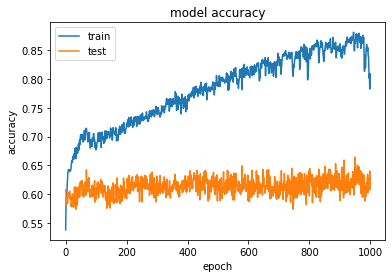

In [147]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

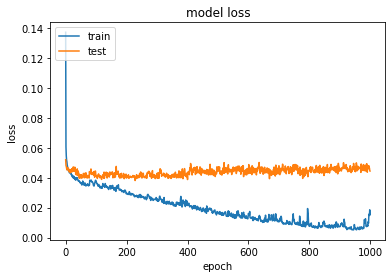

In [149]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'test'], loc='upper left')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [135]:
history.history
print('overall loss' , np.mean(history.history['loss']))
print('overall val_loss' , np.mean(history.history['val_loss']))

overall loss 0.01961241696588695
overall val_loss 0.04381652967631817


In [136]:
predicted_y = model.predict(test_X)


In [137]:
print(predicted_y.shape)
print(test_y.shape)

(524, 60, 2)
(524, 60, 2)


In [138]:
predicted_valence = predicted_y[:,:,0]
predicted_arousal = predicted_y[:,:,1]
test_valence = test_y[:,:,0]
test_arousal = test_y[:,:,1]

In [139]:
# for i in range(1):
  # print(predicted_valence[i])
  # print(predicted_arousal[i])
  # print(test_valence[i])
  # print(test_arousal[i])

In [140]:
predicted_valence = predicted_valence.reshape(31440,)
test_valence = test_valence.reshape(31440,)
predicted_arousal = predicted_arousal.reshape(31440,)
test_arousal = test_arousal.reshape(31440,)

In [141]:
def metrics(y_true,y_pred,name):
  print(name,"")
  mae = mean_absolute_error(y_true,y_pred)
  rmse = sqrt(mean_squared_error(y_true,y_pred))
  r2 = r2_score(y_true,y_pred)
  pearson_corr = pearsonr(y_true,y_pred)
  spearman_corr = spearmanr(y_true,y_pred)
  
  print('RMSE : ',rmse)
  print('Pearson : ',pearson_corr)
  print('MAE : ',mae)
  print('R2 : ',r2)
  print('Spearman : ',spearman_corr,'\n')


In [142]:
def graph_results(x,y,title, xlim=-1, ylim=-1):
  #x and y are variables ( y_pred vs y_true )
  #Important
  plt.scatter(x,y,s=15)

  # if xlim != -1: plt.xlim([0, xlim])
  # if ylim != -1: plt.ylim([0, ylim])
  # plt.gca().set_ylim([1.5,7.5])
  # plt.gca().set_xlim([1.5,9])
  #Fix 
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title((title))
  # m, b = np.polyfit(x, y, 1)
  # plt.plot(x, m*x + b, color='red')  
  plt.savefig(title)

  plt.show()

valence 
RMSE :  0.2238339950562115
Pearson :  (0.3819321631930297, 0.0)
MAE :  0.17708742773765349
R2 :  0.07995202229957765
Spearman :  SpearmanrResult(correlation=0.3755387380283031, pvalue=0.0) 



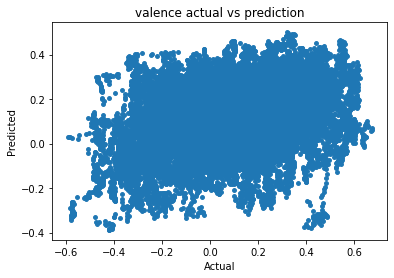

In [143]:
metrics(test_valence,predicted_valence,'valence')
graph_results(test_valence,predicted_valence,'valence actual vs prediction')


arousal 
RMSE :  0.18374660912071494
Pearson :  (0.7612326678372261, 0.0)
MAE :  0.14489361070250145
R2 :  0.578659824657298
Spearman :  SpearmanrResult(correlation=0.7600936624314226, pvalue=0.0) 



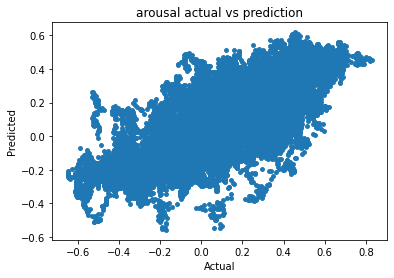

In [144]:
metrics(test_arousal,predicted_arousal,'arousal')
graph_results(test_arousal,predicted_arousal,'arousal actual vs prediction')